The SME division head proposed that we give a 20% discount to high propensity to churn customers. We can assume to start that everyone who is offered a discount will accept it.

### Workflow
Our task is to calculate the forecast revenue for the set of customers:

1. When no discount is offered
2. when a discount is offered based on a probability cutoff to decide who should receive the 20% discount

And hence to decide where the cut-off should be set in order to maximise revenue

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
test_df = pd.read_csv('out_of_sample_data_with_predictions.csv')
test_df = test_df.drop(columns = ['Unnamed: 0'])
test_df.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability
0,5.900308,0.000000,4.989517,3.699890,0.0,1.235023,0.165022,0.086380,44.311378,0,...,0,0,0,1,0,1,0,0,0,0.054
1,4.268578,4.164026,3.198107,3.295956,0.0,2.119454,0.118636,0.101750,40.606701,1,...,0,0,0,1,0,0,1,0,0,0.056
2,4.066400,0.000000,3.127105,3.087902,0.0,2.167908,0.116910,0.100572,40.606701,0,...,0,0,1,0,0,0,0,1,0,0.035
3,2.873902,0.000000,1.897627,2.052232,0.0,1.305136,0.142881,0.000000,46.305378,0,...,1,0,0,0,0,1,0,0,0,0.028
4,4.179207,4.068520,3.164947,3.214531,0.0,2.158423,0.117496,0.101155,40.606701,1,...,0,0,1,0,0,0,0,1,0,0.145


### Calculate a baseline revenue estimate (no intervention)

Calculate a baseline estimate of the electricity revenue for every customer for the next twelve months based on the forecast consumption and forecast
price and actual churn outcome. Call this `basecase_revenue`.

- For customers who end up churning, we should reduce our forecast revenue calculation by 91.95% to account for the customers churn some time between January 2016 and the start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%, corresponding to churn at the end of February, or 59 days into a 365 day year). Call this new variable `basecase_revenue_after_churn`, ie `basecase_revenue_after_churn` = `basecase_revenue`*(1 -0.9195 * `churn`)

In [14]:
# Electricity revenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step
test_df['basecase_revenue'] = (np.power(10, test_df['forecast_cons_12m']) + 1) * test_df['forecast_price_energy_off_peak'] + test_df['forecast_meter_rent_12m']

# Taking churn into account
test_df['basecase_revenue_after_churn'] = test_df['basecase_revenue'] * (1 - 0.9195 * test_df['churn'])

## Calculate the estimated benefits and costs of intervention

Now, pick a cut-off probability (eg 0.5) so that:

- Customers with a higher churn probability than the cut-off get a discount, and
- Customers below the churn-probability do not get a discount.

From this, calculate the revenue of the intervention scenario assuming:
- All customers who are offered a discount accept it
- Customers who do receive a discount are are assumed not to churn in the next twelve months (ie churn probability = 0), and therefore the retained
revenue is 0.8*`basecase_revenue` , being (1-`discount_fraction`)*`basecase_revenue`
- Customers who do not receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for whether they actually
churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph. What cut-off probability approximately optimises the revenue outcome? Assume for these calculations that the customer does not consume more or less electricity because the price changes. In practice, we would expect that if the customer's cost goes down then their consumption might increase. We will see two counterbalancing effects at play:

- For true positives we will see revenue retention vs the no-discount scenario
- For false positives we will see reduced revenue from giving them a discount when they wouldn't in fact churn.

(False negatives represent an opportunity cost but not an actual cost difference between the two scenarios.)

The optimal cut-off point will balance the benefits from true positives against the costs of false positives. Our task is to approximately find the optimal cut-off point. We may need to make additional assumptions. If we feel the assumptions above aren't justified and that others are better then we should modify our assumptions.

In [15]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2) -> float:
    
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given => customer stays for full year, independent of whether the prediction
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

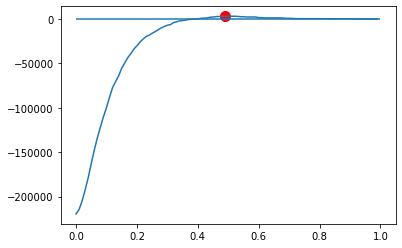

Maximum benefit at cutoff 0.49 with revenue delta of $3,140.36


In [16]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})

def plot_tradeoff(rev_deltas: pd.Series):
    # Plot the revenue deltas
    rev_deltas.plot()
    # Mark optimal point
    max_pred = rev_deltas.idxmax()
    plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
    # Reference line for break-even
    plt.hlines(0, 0, 1)
    plt.show()
    print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')

plot_tradeoff(rev_deltas)

## How to select the cut-off?

Above, we decided who to offer the discount to based on a probability cut-off. Is this the optimal strategy?

- For instance, we might be offering discounts to customers who are not very profitable, thus worsening our overall margins substantially. For example, if offering a discount makes the customer unprofitable on a net margin basis then we might want to let them churn rather than save them.
- Even if we only consider revenue, this strategy might not be optimal from a revenue viewpoint. For instance, we can calculate the expected revenue impact of our strategy and prioritise customers for discounts that have a high expected revenue impact. (This means that the probability of churn might be high but they also might be valuable customers).

A general principle here is that we can afford to spend more on retaining high-value customers because the costs of losing them are higher. A very common mistake in business applications of churn is to focus on the churn probability whilst forgetting the value impact (to greater or lesser extents). We have seen many cases where our clients spend as much effort on retaining unprofitable customers as they do on retaining highly profitable customers.

In [17]:
def get_rev_delta_high_value(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2, min_rev: float=500):
    """
    Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff and rev
    """
    pred['discount_revenue'] = pred['basecase_revenue_after_churn']
    # Churn predicted => discount is given for high-value customers => customer stays for full year, independent
    # (false positive, "free"/unnecessary discount given) or correct
    pred.loc[(pred['churn_probability'] >= cutoff) & (pred['basecase_revenue'] > min_rev),
    'discount_revenue'] = pred['basecase_revenue'] * (1 - discount)
    # Save the revenue delta for each customer in a separate column
    pred['revenue_delta'] = pred['discount_revenue'] - pred['basecase_revenue_after_churn']
    return pred['revenue_delta'].sum()

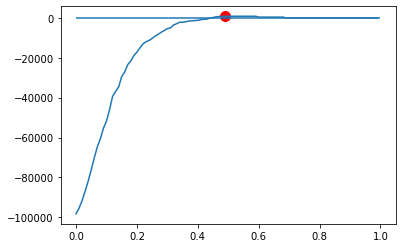

Maximum benefit at cutoff 0.49 with revenue delta of $835.52


In [18]:
## Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas_high_value = pd.Series({cutoff: get_rev_delta_high_value(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
plot_tradeoff(rev_deltas_high_value)

<b>Note:</b> 

- In this case, it doesn't make sense to prioritize large-revenue customers, since the overall revenue delta is much lower than when targeting everyone. However, this is only the case here since the intervention doesn't depend on the number of customers (simply adjusting prices). The interventions usually go beyond simply adjusting prices to prevent churn. 
- There may be the option of intensifying the customer relation, adding key account managers, or other interventions that do incur costs depending on how many customers are targeted. In that case, it may be benefitial to target only a subset of customers to save on these costs, even if the delta in the figure above is reduced.

## Using forecast rather than actual churn

We may have noticed above that we used actual churn outcomes in calculating the financial impact. Actual churn outcomes are fine if we know them and are conducting a retrospective analysis of the effectiveness of a strategy. This example of analysis is commonly known as "backtesting", ie seeing how well a strategy would have performed historically.

Of course, one must be careful that any analysis is done using out-of-sample data. Conducting the analysis on the training data will lead to predictions that are too optimistic.

In practice, actual outcomes may not be available because they are in the future. An alternative is to optimise predicted/forecast revenue based on the probabilities which are an output from our churn model. In this case, we would replace the actual churn outcomes (`churn`) with the predicted probability of churn from our model. The results here are obviously model-dependent.

If our model probabilities are poorly calibrated then we can end up with quite poor results from this. Going down this path therefore usually requires the extra step of checking how well calibrated the model probabilities are, and potentially correcting for any miscalibration using Platt scaling, sigmoid calibration or isotonic regression.

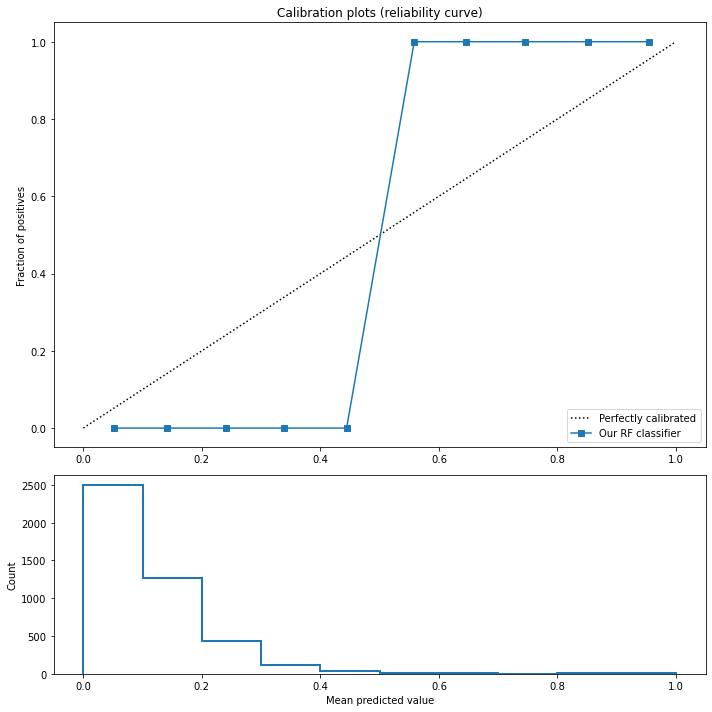

In [26]:
# Check our calibration
# (code copied from https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html)
from sklearn.calibration import calibration_curve

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true=test_df['churn'],
    y_prob=test_df['churn_probability'],
    n_bins=10
)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Our RF classifier")
ax2.hist(test_df['churn_probability'], range=(0, 1), bins=10, histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05,1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
plt.tight_layout()

In [27]:
# Electricity evenue for each customer consists of energy consumption (amount * price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more d
# Note that we need to reverse the log10-transformation from the data cleaning step
test_df['basecase_revenue'] = np.power(10, test_df['forecast_cons_12m']) * test_df['forecast_price_energy_off_peak'] + test_df['forecast_meter_rent_12m']
# Taking churn into account
test_df['basecase_revenue_after_churn'] = test_df['basecase_revenue'] * (1 - 0.919 * test_df['churn_probability'])

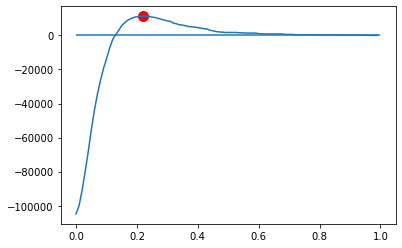

Maximum benefit at cutoff 0.22 with revenue delta of $11,258.67


In [28]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
plot_tradeoff(rev_deltas)

In [29]:
#check how many increased
test_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw,churn,churn_probability,basecase_revenue,basecase_revenue_after_churn,discount_revenue,revenue_delta
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,...,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.0
mean,4.235055,0.762614,2.240275,2.979752,1.022821,1.519105,0.136903,0.049583,43.094967,0.176632,...,0.098357,0.293702,0.216796,0.483797,0.006618,0.110682,254.986312,227.910540,227.910540,0.0
std,0.857369,1.700799,1.776893,0.668872,5.267891,0.573715,0.024256,0.049339,4.432687,0.381400,...,0.297831,0.455509,0.412110,0.499794,0.081091,0.097423,298.199139,261.165038,261.165038,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,3.770650,0.000000,0.000000,2.710959,0.000000,1.234770,0.116339,0.000000,40.606701,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.045000,72.871152,65.135356,65.135356,0.0
50%,4.159326,0.000000,2.898176,3.056606,0.000000,1.294907,0.143166,0.083125,44.311378,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.084500,158.473940,143.842826,143.842826,0.0
75%,4.609826,0.000000,3.530808,3.397934,0.000000,2.120566,0.146348,0.098837,44.311378,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.148000,332.246859,298.471722,298.471722,0.0
max,6.792889,6.618528,5.887169,4.496211,30.000000,2.778376,0.273963,0.195975,59.266378,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.984000,4192.451030,3273.498262,3273.498262,0.0


In [30]:
test_df['churn'].value_counts()

0    4353
1      29
Name: churn, dtype: int64

In [33]:
loss = test_df['basecase_revenue'].sum() - test_df['basecase_revenue_after_churn'].sum()
loss

118646.03651641274

In [35]:
reduced_loss = 11258.67/loss *100
reduced_loss

9.489292968031467